# Image classification

### Descripción
En este problema, se proporciona un conjunto de datos que contiene imágenes de escenas naturales de todo el mundo. El objetivo es construir un modelo de clasificación utilizando redes neuronales convolucionales (CNN) para clasificar estas imágenes en una de las seis categorías predefinidas.


### Objetivo
Utilizando el dataset proporcionado, el objetivo es construir y comparar el rendimiento de distintos modelos de clasificación de imágenes utilizando redes neuronales convolucionales y densas que puedan clasificar con precisión las imágenes de escenas naturales en una de las seis categorías mencionadas anteriormente.
Los modelos a diseñar son:
- Modelo con capas densas.

- Modelo con capas convolucionales y densas.

- Modelo que incluya bloques residuales identidad:

- Modelo que utilice como backbone alguna de las arquitecturas disponibles en TensorFlow (transfer learning): https://www.tensorflow.org/api_docs/python/tf/keras/applications

Se debe entrenar y evaluar cada modelo utilizando técnicas adecuadas de validación y métricas de evaluación de clasificación.

Se comienza por importar las librerías necesarias

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.layers import Input, RandomFlip, RandomContrast, BatchNormalization, RandomTranslation, Dropout, Rescaling
from keras.layers import Conv2D, Activation, MaxPooling2D, GlobalMaxPooling2D, Add
from PIL import Image
from sklearn.feature_extraction import image
from sklearn.preprocessing import LabelEncoder
from skimage import io
import cv2
import os
import random
import zipfile
import gdown
from pathlib import Path

import warnings
warnings.filterwarnings("ignore")

2024-05-02 18:47:23.115931: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-02 18:47:25.918348: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## 1 - Análisis Exploratorio (EDA)

Se comenzará haciendo un análisis explotarorio del dataset para conocer sus características principales y evaluar si es necesario hacer algún proceso antes de comenzar.

### 1.1 - Importar el dataset y visualizar el dataframe

In [2]:
# TP1-3-natural-scenes.zip
gdown.download('https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ')

Downloading...
From (original): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ
From (redirected): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ&confirm=t&uuid=4ad8140e-7a8d-4dbb-abd7-f67e93df3430
To: /home/flor/Artificial-Intelligence/Artificial-Intelligence/Aprendizaje-Automatico-II/TP/TP1/DeepLearning_TP1/TP1-3-natural-scenes.zip
 14%|█▍        | 51.4M/363M [00:04<00:23, 13.1MB/s]

KeyboardInterrupt: 

In [3]:
with zipfile.ZipFile('TP1-3-natural-scenes.zip', 'r') as zip_ref:
    zip_ref.extractall('./TP1-3')

### Dataset

El dataset proporcionado contiene alrededor de 25,000 imágenes de tamaño 150x150, distribuidas en seis categorías:
- buildings
- forest
- glacier
- mountain
- sea
- street

Las imágenes están divididas en tres conjuntos:

- Train: Alrededor de 14,000 imágenes para entrenamiento.

- Test: Alrededor de 3,000 imágenes para evaluación del modelo.

- Prediction: Alrededor de 7,000 imágenes para predicción final.

Se carga el dataset

In [17]:
# Directorio de los datos
TRAIN_DATA_DIRECTORY = Path("TP1-3/seg_train/seg_train")
VALIDATION_DATA_DIRECTORY = Path("TP1-3/seg_test/seg_test")

# Tamaño del lote (batch size)
BATCH_SIZE = 64
# Tamaño de las imágenes
IMAGE_HEIGHT = 96
IMAGE_WIDTH = 96

# Carga los datos de entrenamiento y validación
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DATA_DIRECTORY,
    label_mode="categorical",
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VALIDATION_DATA_DIRECTORY,
    label_mode="categorical",
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


Establecer GPU por defecto en caso de estar disponible.

In [19]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

### 1.2 - Visualización de imágenes de ejemplo

Se inspeccionan las clases

In [18]:
# Obtiene los nombres de las clases
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


Se visualizan algunos datos de ejemplo

2024-05-01 14:31:05.259175: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


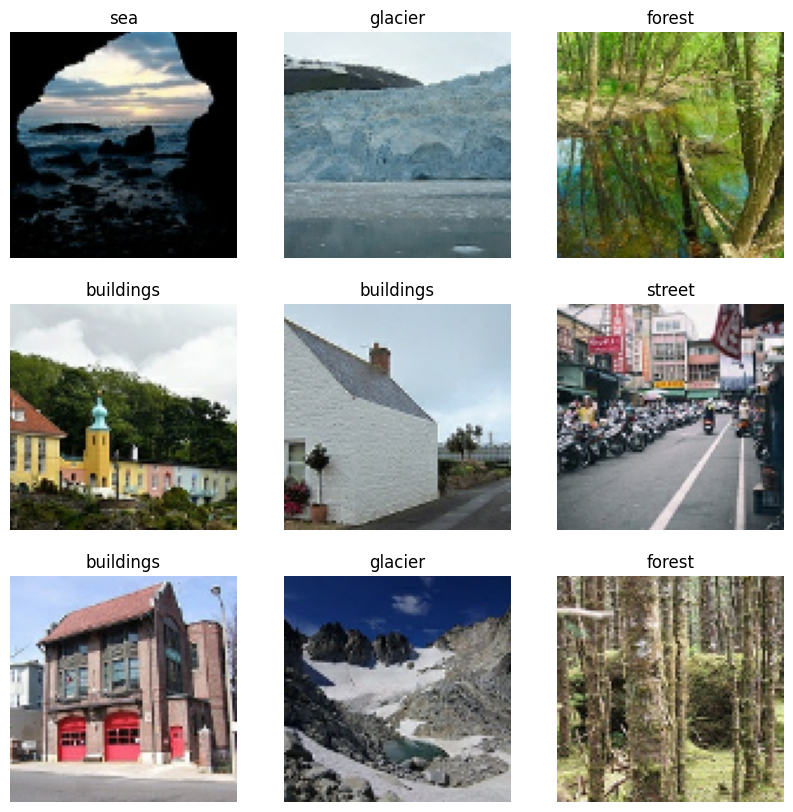

In [21]:
# Muestra algunas imágenes de ejemplo
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_idx = list(labels[i]).index(1)
    plt.title(class_names[class_idx])
    plt.axis("off")

In [39]:
# Función para cargar y mostrar una imagen
def show_image(image_path):
    image = cv2.imread(str(image_path))
    label = image_path.parent.name
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f'Imagen de ejemplo para la clase: {label}')
    plt.show()

# Función para verificar el tamaño de las imágenes
def check_image_sizes(image_dir):
    image_sizes = set()
    for filename in os.listdir(image_dir):
        image_path = os.path.join(image_dir, filename)
        image = cv2.imread(image_path)
        height, width, _ = image.shape
        image_sizes.add((height, width))
    return image_sizes

# Función para verificar el formato de las imágenes
def check_image_formats(image_dir):
    image_formats = set()
    for filename in os.listdir(image_dir):
        image_path = os.path.join(image_dir, filename)
        image = cv2.imread(image_path)
        image_formats.add(image.shape[2])  # 2 para obtener el número de canales de color
    return image_formats

# Función para verificar el balance de clases
def check_class_balance(image_dir):
    class_counts = {}
    for class_name in os.listdir(image_dir):
        class_path = os.path.join(image_dir, class_name)
        class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

In [40]:
# Directorio de imágenes
image_class_directory = Path("TP1-3/seg_train/seg_train")

Clase: buildings


Tamaños de imágenes encontrados: {(124, 150), (150, 150)}
Formatos de imágenes encontrados. Número de canales de color: {3}


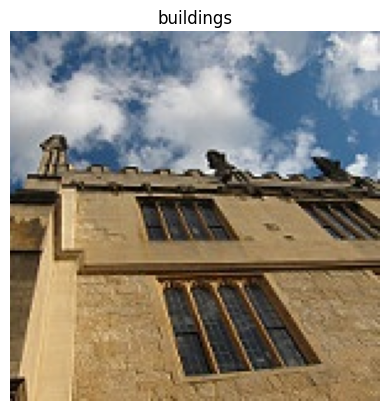

----------------------------------------------------


Clase: forest
Tamaños de imágenes encontrados: {(115, 150), (113, 150), (108, 150), (133, 150), (150, 150), (135, 150), (136, 150)}
Formatos de imágenes encontrados. Número de canales de color: {3}


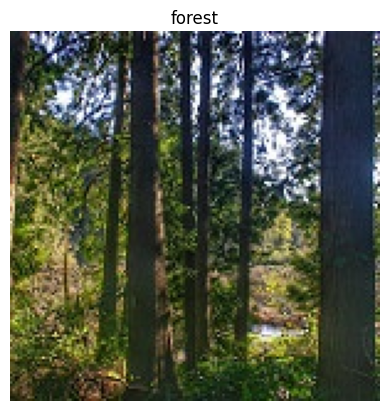

----------------------------------------------------


Clase: glacier
Tamaños de imágenes encontrados: {(143, 150), (135, 150), (146, 150), (120, 150), (142, 150), (134, 150), (105, 150), (149, 150), (111, 150), (123, 150), (150, 150), (102, 150), (97, 150), (119, 150), (76, 150), (110, 150)}
Formatos de imágenes encontrados. Número de canales de color: {3}


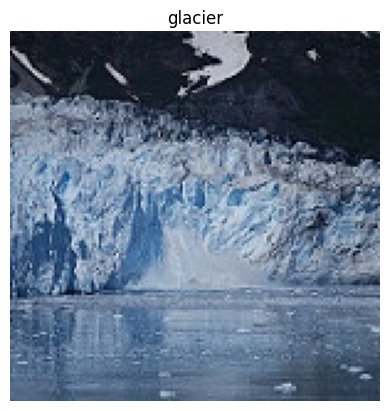

----------------------------------------------------


Clase: mountain
Tamaños de imágenes encontrados: {(143, 150), (141, 150), (146, 150), (145, 150), (142, 150), (134, 150), (113, 150), (100, 150), (144, 150), (147, 150), (150, 150), (123, 150), (135, 150), (81, 150), (103, 150), (136, 150), (131, 150)}
Formatos de imágenes encontrados. Número de canales de color: {3}


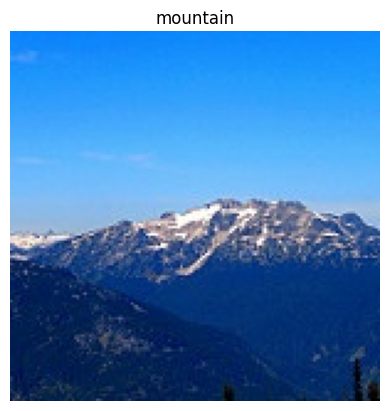

----------------------------------------------------


Clase: sea
Tamaños de imágenes encontrados: {(140, 150), (113, 150), (150, 150)}
Formatos de imágenes encontrados. Número de canales de color: {3}


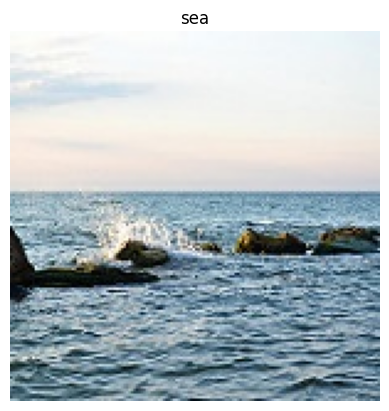

----------------------------------------------------


Clase: street
Tamaños de imágenes encontrados: {(113, 150), (150, 150)}
Formatos de imágenes encontrados. Número de canales de color: {3}


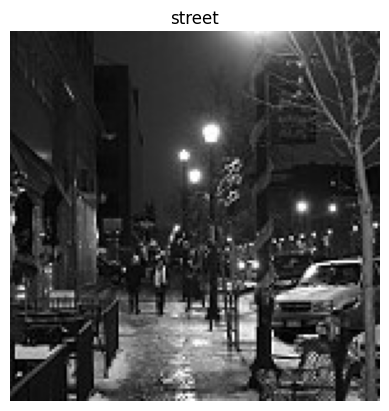

----------------------------------------------------




In [43]:
for image_class in class_names:
    print(f'Clase: {image_class}')
    image_directory = Path(f"TP1-3/seg_train/seg_train/{image_class}")
    # Verificar tamaño de imágenes
    image_sizes = check_image_sizes(image_directory)
    print("Tamaños de imágenes encontrados:", image_sizes)

    # Verificar formato de imágenes
    image_formats = check_image_formats(image_directory)
    print("Formatos de imágenes encontrados. Número de canales de color:", image_formats)

    # Get list of test image paths
    test_image_paths = list(image_directory.glob("*.jpg"))
    sample_image_path = random.choice(test_image_paths)
    show_image(sample_image_path)
    
    print('----------------------------------------------------')
    print('\n')

In [44]:
# Verificar balance de clases
class_balance = check_class_balance(image_class_directory)
print("Balance de clases:", class_balance)

Balance de clases: {'forest': 2271, 'sea': 2274, 'mountain': 2512, 'street': 2382, 'buildings': 2191, 'glacier': 2404}


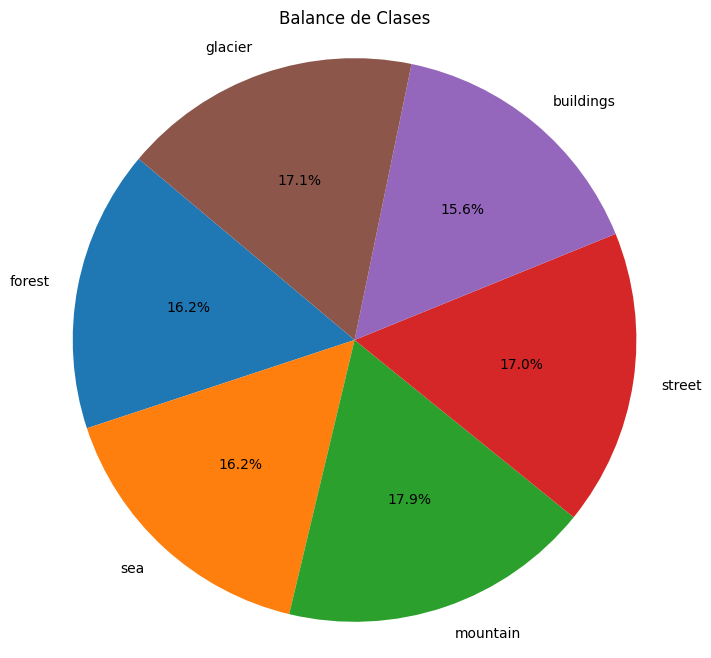

In [45]:
# Extraer nombres de clases y sus respectivos valores
class_names = list(class_balance.keys())
class_counts = list(class_balance.values())

# Crear el gráfico de torta
plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=class_names, autopct='%1.1f%%', startangle=140)
plt.title('Balance de Clases')
plt.axis('equal')  # Hace que el gráfico de torta sea circular
plt.show()

## 2 - Arquitecturas de la red

### 2.1 - Redes densas

In [6]:
def build_classification_model(num_layers, num_neurons, input_shape):
    i = Input(input_shape, dtype=tf.float32)
    x = Rescaling(1./255)(i)
    x = RandomFlip("horizontal")(x)
    x = RandomFlip("vertical")(x)
    x = RandomTranslation(0.1, 0.1, fill_mode="reflect")(x)
    x = RandomContrast(0.2)(x)
    
    model = keras.Sequential()
    model.add(Flatten(input_shape=input_shape))  # Aplana las imágenes antes de la capa densa

    for _ in range(num_layers):
        model.add(Dense(num_neurons, activation='relu'))  # Capas ocultas

    model.add(keras.layers.Dropout(0.2))
    model.add(Dense(6, activation='softmax'))  # Capa de salida para clasificación multiclase
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

Se construye el modelo

In [7]:
input_shape = (96, 96, 3)  # Tamaño de las imágenes
num_layers = 7
num_neurons = 128

model_dnn = build_classification_model(num_layers, num_neurons, input_shape)

Resumen del modelo

In [8]:
model_dnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 27648)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,539,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,638,918 (13.88 MB)

 Trainable params: 3,638,918 (13.88 MB)

 Non-trainable params: 0 (0.00 B)

Se entrena el modelo

In [9]:
# Número de épocas de entrenamiento
EPOCHS = 20

history = model_dnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

Epoch 1/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 32s 113ms/step - accuracy: 0.2310 - loss: 60.7770 - val_accuracy: 0.4017 - val_loss: 1.6075
Epoch 2/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 24s 110ms/step - accuracy: 0.3899 - loss: 1.5808 - val_accuracy: 0.4517 - val_loss: 1.4297
Epoch 3/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 23s 103ms/step - accuracy: 0.4203 - loss: 1.4654 - val_accuracy: 0.4107 - val_loss: 1.5618
Epoch 4/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 21s 93ms/step - accuracy: 0.4303 - loss: 1.4591 - val_accuracy: 0.4597 - val_loss: 1.3819
Epoch 5/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 24s 110ms/step - accuracy: 0.4175 - loss: 1.4537 - val_accuracy: 0.4237 - val_loss: 1.4116
Epoch 6/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 24s 110ms/step - accuracy: 0.4692 - loss: 1.3541 - val_accuracy: 0.5083 - val_loss: 1.3215
Epoch 7/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 23s 104ms/step - accuracy: 0.4823 - loss: 1.3237 - val_accuracy: 0.4580 - val_loss: 1.3739
Epoch 8/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - accuracy: 0.4819 - loss: 1.

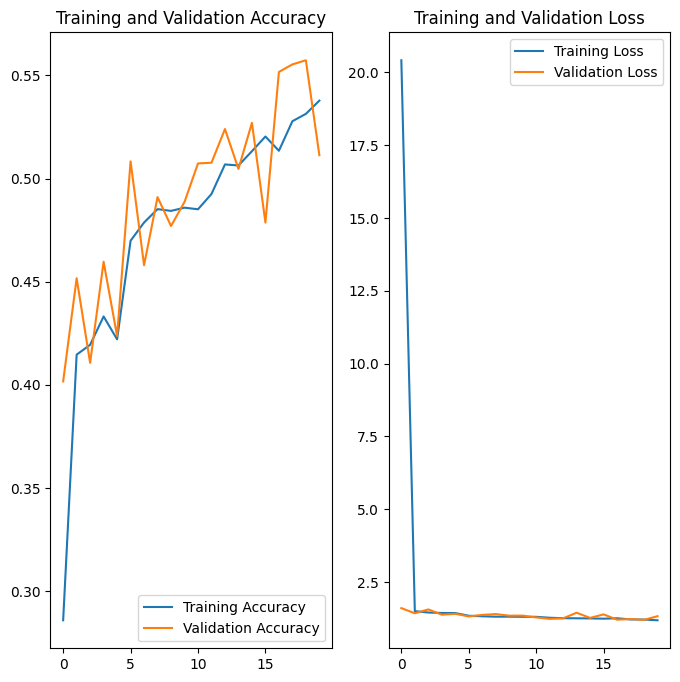

In [11]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Realizar predicciones

In [13]:
# Directorio de las imágenes de prueba
TEST_DATA_DIRECTORY = Path("TP1-3/seg_pred/seg_pred")

# Obtener la lista de rutas de las imágenes de prueba
test_image_paths = list(TEST_DATA_DIRECTORY.glob("*.jpg"))

# Lista para almacenar las imágenes cargadas
test_images = []
for image_path in test_image_paths:
    # Cargar la imagen y redimensionarla según sea necesario
    img = load_img(image_path, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
    # Convertir la imagen a un array numpy
    img_array = img_to_array(img)    
    # Agregar la imagen al conjunto de datos
    test_images.append(img_array)

# Convertir la lista de imágenes a un array numpy
test_images = np.array(test_images)

In [14]:
# Evaluar el modelo en el conjunto de validación
val_predictions = model_dnn.predict(test_images)
# Obtener clases estimadas (convertir probabilidades a clases)
predicted_classes = np.argmax(val_predictions, axis=1)# Evaluar el modelo en el conjunto de validación

2024-04-30 20:05:46.484396: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 807432192 exceeds 10% of free system memory.


229/229 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step


Se visualizan ejemplos de imágenes con sus corespondientes predicciones

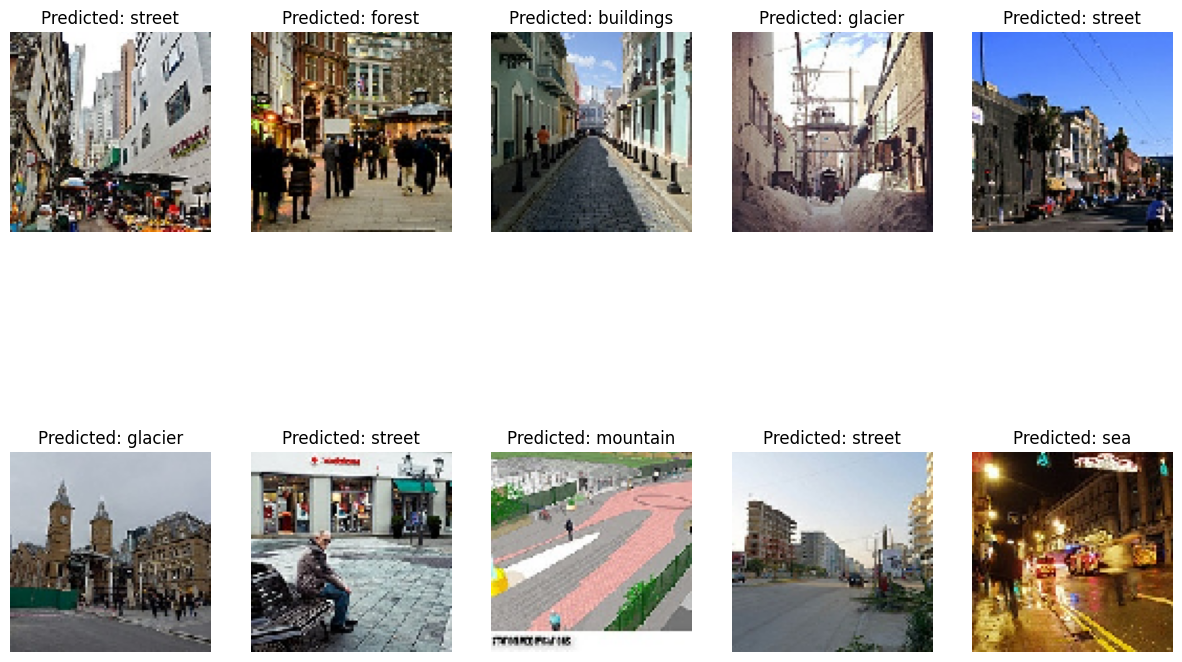

In [50]:
# Obtener las primeras 10 imágenes y sus etiquetas predichas
num_images = 10
sample_images = []
for i in range(0,10):
    image_path = test_image_paths[i]
    # Cargar la imagen y redimensionarla según sea necesario
    img = load_img(image_path, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
    sample_images.append(img)
    
sample_predicted_labels = np.argmax(val_predictions[:num_images], axis=1)

# Obtener los nombres de las clases
class_names = ['forest', 'sea', 'mountain', 'street', 'buildings', 'glacier']

# Mostrar las imágenes junto con sus etiquetas predichas
plt.figure(figsize=(15, 10))
for i in range(num_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(sample_images[i])
    plt.title('Predicted: ' + class_names[sample_predicted_labels[i]])
    plt.axis('off')
plt.show()

### 2.2 - Redes convolucionales

In [52]:
def build_classification_model_cnn(input_shape, output_labels):
    i = Input(input_shape, dtype=tf.float32)
    x = Rescaling(1./255)(i)
    x = RandomFlip("horizontal")(x)
    x = RandomFlip("vertical")(x)
    x = RandomTranslation(0.1, 0.1, fill_mode="reflect")(x)
    x = RandomContrast(0.2)(x)
    
    x = Conv2D(8, (3, 3))(x)
    x = Activation("relu")(x)

    x = Conv2D(16, (3, 3))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(32, (3, 3))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dropout(0.3)(x)
    x = Dense(output_labels)(x)
    x = Activation("softmax")(x)
    return tf.keras.Model(inputs=[i], outputs=[x])

In [53]:
print("Building model")
model_cnn = build_classification_model_cnn((IMAGE_HEIGHT, IMAGE_WIDTH, 3), 6)

model_cnn.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'])

Building model


In [54]:
model_cnn.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_2 (RandomFlip)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_3 (RandomFlip)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation_1            │ (None, 96, 96, 3)      │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_1               │ (None, 96, 96, 3)      │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 94, 94, 8)      │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 94, 94, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 92, 92, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 92, 92, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 44, 44, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 44, 44, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 20, 20, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 6)              │        38,406 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 6)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,934 (245.84 KB)

 Trainable params: 62,934 (245.84 KB)

 Non-trainable params: 0 (0.00 B)

Se entrena el modelo

In [55]:
# Número de épocas de entrenamiento
EPOCHS = 30
# Entrena el modelo
history = model_cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

Epoch 1/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 161s 705ms/step - accuracy: 0.4295 - loss: 1.3665 - val_accuracy: 0.5530 - val_loss: 1.1271
Epoch 2/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 160s 722ms/step - accuracy: 0.6103 - loss: 0.9983 - val_accuracy: 0.6287 - val_loss: 1.0043
Epoch 3/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 197s 701ms/step - accuracy: 0.6490 - loss: 0.9126 - val_accuracy: 0.7027 - val_loss: 0.8091
Epoch 4/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 198s 686ms/step - accuracy: 0.6798 - loss: 0.8278 - val_accuracy: 0.6983 - val_loss: 0.8020
Epoch 5/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 151s 684ms/step - accuracy: 0.7178 - loss: 0.7536 - val_accuracy: 0.7287 - val_loss: 0.7509
Epoch 6/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 201s 680ms/step - accuracy: 0.7233 - loss: 0.7307 - val_accuracy: 0.7193 - val_loss: 0.7298
Epoch 7/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 202s 680ms/step - accuracy: 0.7473 - loss: 0.6864 - val_accuracy: 0.7447 - val_loss: 0.7235
Epoch 8/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 148s 670ms/step - accuracy: 0.7427 -

Visualizar resultados de entrenamiento

In [ ]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Realizar predicciones

In [ ]:
# Directorio de las imágenes de prueba
TEST_DATA_DIRECTORY = Path("TP1-3/seg_pred/seg_pred")

# Obtener la lista de rutas de las imágenes de prueba
test_image_paths = list(TEST_DATA_DIRECTORY.glob("*.jpg"))

# Lista para almacenar las imágenes cargadas
test_images = []
for image_path in test_image_paths:
    # Cargar la imagen y redimensionarla según sea necesario
    img = load_img(image_path, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
    # Convertir la imagen a un array numpy
    img_array = img_to_array(img)    
    # Agregar la imagen al conjunto de datos
    test_images.append(img_array)

# Convertir la lista de imágenes a un array numpy
test_images = np.array(test_images)

In [ ]:
# Evaluar el modelo en el conjunto de validación
val_predictions_cnn = model_cnn.predict(test_images)
# Obtener clases estimadas (convertir probabilidades a clases)
predicted_classes_cnn = np.argmax(val_predictions_cnn, axis=1)# Evaluar el modelo en el conjunto de validación

Se visualizan ejemplos de imágenes con sus corespondientes predicciones

In [ ]:
# Obtener las primeras 10 imágenes y sus etiquetas predichas
num_images = 10
sample_images = []
for i in range(0,10):
    image_path = test_image_paths[i]
    # Cargar la imagen y redimensionarla según sea necesario
    img = load_img(image_path, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
    sample_images.append(img)
    
sample_predicted_labels = np.argmax(val_predictions_cnn[:num_images], axis=1)

# Obtener los nombres de las clases
class_names = ['forest', 'sea', 'mountain', 'street', 'buildings', 'glacier']

# Mostrar las imágenes junto con sus etiquetas predichas
plt.figure(figsize=(15, 10))
for i in range(num_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(sample_images[i])
    plt.title('Predicted: ' + class_names[sample_predicted_labels[i]])
    plt.axis('off')
plt.show()

### 2.3 - Redes neuronales con bloques ResNet

Se modificará el modelo para incluir bloques de ResNet según la siguiente estructura simplificada

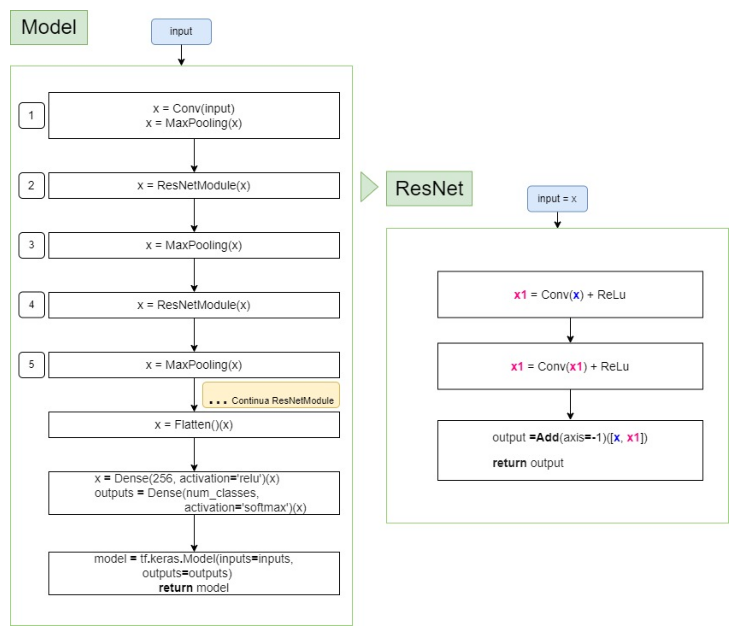

In [6]:
# Cargar la imagen
model_structure_image_path = 'Redes_cnn_con_bloques_ResNet.jpg'
image = cv2.imread(str(model_structure_image_path))

# Crear una figura con un tamaño específico
plt.figure(figsize=(15, 8))

# Mostrar la imagen con el nuevo tamaño
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

Se define el bloque ResNet

In [11]:
def resnet_module(x, filters):
    # Conv 3x3
    conv = Conv2D(filters=filters[0], kernel_size=(3, 3), activation='relu', padding='same')(x)
    
    # Conv 3x3
    conv = Conv2D(filters=filters[1], kernel_size=(3, 3), activation='relu', padding='same')(conv)
   
    # Conv 1x1
    x = Conv2D(filters=filters[1], kernel_size=(1, 1), activation='relu', padding='same')(x)

    # Adición de entrada y salida 
    output = Add()([x, conv])
    
    return output

Se define una función para construir el modelo

In [34]:
def cnn_ResNet(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    x = Rescaling(1./255)(inputs)
    x = RandomFlip("horizontal")(x)
    x = RandomFlip("vertical")(x)
    x = RandomTranslation(0.1, 0.1, fill_mode="reflect")(x)
    x = RandomContrast(0.2)(x)

    x = Conv2D(64, (7, 7), strides=(2, 2), activation='relu', padding='same')(inputs)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    
    x = resnet_module(x, [64, 32])
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x) 
    
    x = resnet_module(x, [32, 96])
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x) 
    
    x = resnet_module(x, [96, 128])
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x) 
    
    # Max pooling final
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x) 
    
    x = Flatten()(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

Se inicializa el modelo

In [35]:
input_shape = (96, 96, 3)
num_classes = 6
model_cnn_resnet = cnn_ResNet(input_shape, num_classes)

Se compila el modelo

In [36]:
model_cnn_resnet.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'])

In [37]:
model_cnn_resnet.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_50 (Conv2D)  │ (None, 48, 48,    │      9,472 │ input_layer_5[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_23    │ (None, 24, 24,    │          0 │ conv2d_50[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_51 (Conv2D)  │ (None, 24, 24,    │     36,928 │ max_pooling2d_23… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_53 (Conv2D)  │ (None, 24, 24,    │      2,080 │ max_pooling2d_23… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_52 (Conv2D)  │ (None, 24, 24,    │     18,464 │ conv2d_51[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_15 (Add)        │ (None, 24, 24,    │          0 │ conv2d_53[0][0],  │
│                     │ 32)               │            │ conv2d_52[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_24    │ (None, 12, 12,    │          0 │ add_15[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_54 (Conv2D)  │ (None, 12, 12,    │      9,248 │ max_pooling2d_24… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_56 (Conv2D)  │ (None, 12, 12,    │      3,168 │ max_pooling2d_24… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_55 (Conv2D)  │ (None, 12, 12,    │     27,744 │ conv2d_54[0][0]   │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 12, 12,    │          0 │ conv2d_56[0][0],  │
│                     │ 96)               │            │ conv2d_55[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_25    │ (None, 6, 6, 96)  │          0 │ add_16[0][0]      │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 6, 6, 96)  │     83,040 │ max_pooling2d_25… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_59 (Conv2D)  │ (None, 6, 6, 128) │     12,416 │ max_pooling2d_25… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_58 (Conv2D)  │ (None, 6, 6, 128) │    110,720 │ conv2d_57[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_17 (Add)        │ (None, 6, 6, 128) │          0 │ conv2d_59[0][0],  │
│                     │                   │            │ conv2d_58[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_26    │ (None, 3, 3, 128) │          0 │ add_17[0][0]    

 Total params: 446,150 (1.70 MB)

 Trainable params: 446,150 (1.70 MB)

 Non-trainable params: 0 (0.00 B)

Se entrena el modelo

In [38]:
# Número de épocas de entrenamiento
EPOCHS = 30
# Entrena el modelo
history = model_cnn_resnet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

Epoch 1/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 178s 779ms/step - accuracy: 0.2711 - loss: 12.3456 - val_accuracy: 0.4897 - val_loss: 1.2171
Epoch 2/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 161s 729ms/step - accuracy: 0.5322 - loss: 1.1636 - val_accuracy: 0.6173 - val_loss: 0.9847
Epoch 3/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 157s 715ms/step - accuracy: 0.6006 - loss: 1.0045 - val_accuracy: 0.6197 - val_loss: 0.9575
Epoch 4/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 161s 731ms/step - accuracy: 0.6239 - loss: 0.9547 - val_accuracy: 0.6233 - val_loss: 0.9364
Epoch 5/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 159s 723ms/step - accuracy: 0.6549 - loss: 0.9055 - val_accuracy: 0.6867 - val_loss: 0.8284
Epoch 6/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 161s 731ms/step - accuracy: 0.6773 - loss: 0.8458 - val_accuracy: 0.6170 - val_loss: 0.9911
Epoch 7/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 163s 737ms/step - accuracy: 0.6756 - loss: 0.8517 - val_accuracy: 0.7257 - val_loss: 0.7553
Epoch 8/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 153s 693ms/step - accuracy: 0.6926 

Visualizar resultados de entrenamiento

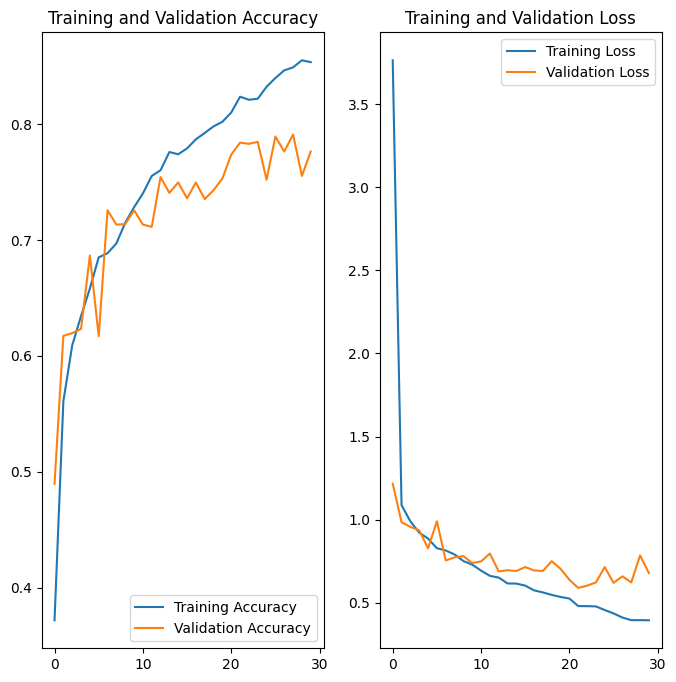

In [40]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc_resnet = history.history['accuracy']
val_acc_resnet = history.history['val_accuracy']

loss_resnet = history.history['loss']
val_loss_resnet = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_resnet, label='Training Accuracy')
plt.plot(epochs_range, val_acc_resnet, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_resnet, label='Training Loss')
plt.plot(epochs_range, val_loss_resnet, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Realizar predicciones

In [41]:
# Directorio de las imágenes de prueba
TEST_DATA_DIRECTORY = Path("TP1-3/seg_pred/seg_pred")

# Obtener la lista de rutas de las imágenes de prueba
test_image_paths = list(TEST_DATA_DIRECTORY.glob("*.jpg"))

# Lista para almacenar las imágenes cargadas
test_images = []
for image_path in test_image_paths:
    # Cargar la imagen y redimensionarla según sea necesario
    img = load_img(image_path, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
    # Convertir la imagen a un array numpy
    img_array = img_to_array(img)    
    # Agregar la imagen al conjunto de datos
    test_images.append(img_array)

# Convertir la lista de imágenes a un array numpy
test_images = np.array(test_images)

In [42]:
# Evaluar el modelo en el conjunto de validación
val_predictions_resnet = model_cnn_resnet.predict(test_images)
# Obtener clases estimadas (convertir probabilidades a clases)
predicted_classes_resnet = np.argmax(val_predictions_resnet, axis=1)# Evaluar el modelo en el conjunto de validación

: 

Se visualizan ejemplos de imágenes con sus correspondientes predicciones

In [ ]:
# Obtener las primeras 10 imágenes y sus etiquetas predichas
num_images = 10
sample_images = []
for i in range(0,10):
    image_path = test_image_paths[i]
    # Cargar la imagen y redimensionarla según sea necesario
    img = load_img(image_path, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
    sample_images.append(img)
    
sample_predicted_labels = np.argmax(val_predictions_resnet[:num_images], axis=1)

# Obtener los nombres de las clases
class_names = ['forest', 'sea', 'mountain', 'street', 'buildings', 'glacier']

# Mostrar las imágenes junto con sus etiquetas predichas
plt.figure(figsize=(15, 10))
for i in range(num_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(sample_images[i])
    plt.title('Predicted: ' + class_names[sample_predicted_labels[i]])
    plt.axis('off')
plt.show()